## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [2]:
# Importing essential libraries and functions
!pip install Keras-Preprocessing

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

   ---------------------------------------- 0.0/42.6 kB ? eta -:--:--
   --------- ------------------------------ 10.2/42.6 kB ? eta -:--:--
   ------------------- -------------------- 20.5/42.6 kB 217.9 kB/s eta 0:00:01
   ---------------------------- ----------- 30.7/42.6 kB 259.2 kB/s eta 0:00:01
   -------------------------------------- - 41.0/42.6 kB 279.3 kB/s eta 0:00:01
   ---------------------------------------- 42.6/42.6 kB 229.4 kB/s eta 0:00:00


## Loading dataset

In [3]:
movie_reviews = pd.read_csv("../data/IMDB_Dataset.csv")

In [4]:
movie_reviews.shape

(50000, 2)

In [5]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

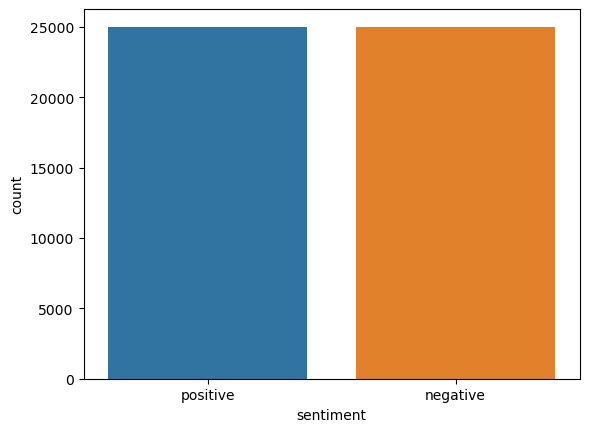

In [7]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [8]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\begat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [10]:
# import b2_preprocessing_function
from b2_preprocessing_function import CustomPreprocess

In [11]:
custom = CustomPreprocess()
custom.preprocess_text("Those were the best days of my life!")

'best days life '

In [12]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [13]:
# Sample cleaned up movie review 

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [14]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [16]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [17]:
import pickle

# Save the tokenizer to a file
with open("../tokeniser/tokenizer.pkl", "wb") as f:
    pickle.dump(word_tokenizer, f)

In [18]:
import io
import json

In [19]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [20]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [21]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../embed/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [23]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [24]:
embedding_matrix.shape

(92394, 100)

## Recurrent Neural Network (LSTM)

In [31]:
from keras.layers import LSTM

In [36]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [37]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [38]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - acc: 0.6971 - loss: 0.5630 - val_acc: 0.8110 - val_loss: 0.4160
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - acc: 0.8108 - loss: 0.4226 - val_acc: 0.8257 - val_loss: 0.3948
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - acc: 0.8360 - loss: 0.3796 - val_acc: 0.8399 - val_loss: 0.3583
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - acc: 0.8561 - loss: 0.3368 - val_acc: 0.8450 - val_loss: 0.3522
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - acc: 0.8617 - loss: 0.3286 - val_acc: 0.8627 - val_loss: 0.3306
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - acc: 0.8706 - loss: 0.3114 - val_acc: 0.8508 - val_loss: 0.3461


In [39]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc: 0.8476 - loss: 0.3527


In [40]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34723788499832153
Test Accuracy: 0.8503999710083008


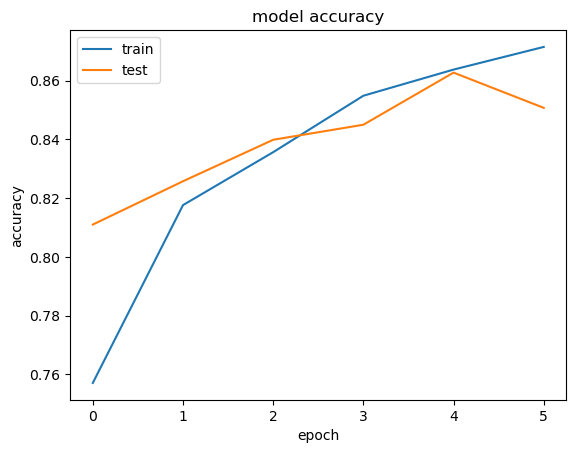

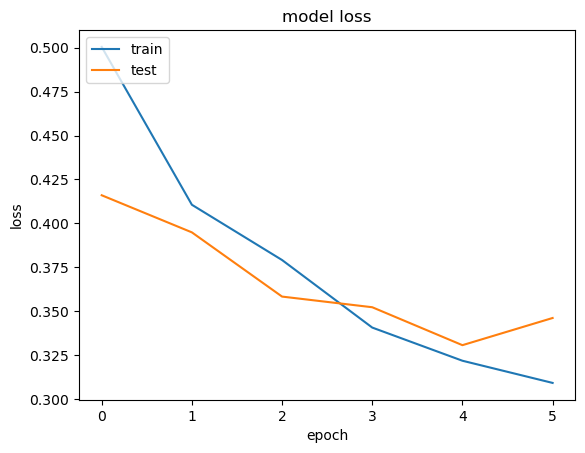

In [41]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [42]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./sentiment{round(score[1], 3)}.h5", save_format='h5')

## Making Predictions on Live IMDb data

In [43]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='../models/model.h5'
pretrained_lstm_model = load_model(model_path)



# Traditional Model (Logistic Regression)

In [44]:
#importing the necessary stuff
import pandas as pd
import numpy as np
import re
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [81]:
from sklearn.model_selection import train_test_split, GridSearchCV

vectorizer = TfidfVectorizer(max_features=100)  # Convert text into TF-IDF vectors
X = vectorizer.fit_transform(movie_reviews['review'])

y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

#Splitting the dataset
X_train_lr, X_test_lr, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [87]:
# 🔹 Step 4: Hyperparameter Tuning with GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=15)
grid_search.fit(X_train, y_train)

# Best Model
lr_model = grid_search.best_estimator_


#Step 4: Train the Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [88]:
#  Step 5: Evaluate the Model
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]  # Probability scores

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Accuracy: 0.5102

 Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.33      0.40      4961
           1       0.51      0.68      0.58      5039

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.49     10000
weighted avg       0.51      0.51      0.49     10000


 Confusion Matrix:
 [[1656 3305]
 [1593 3446]]


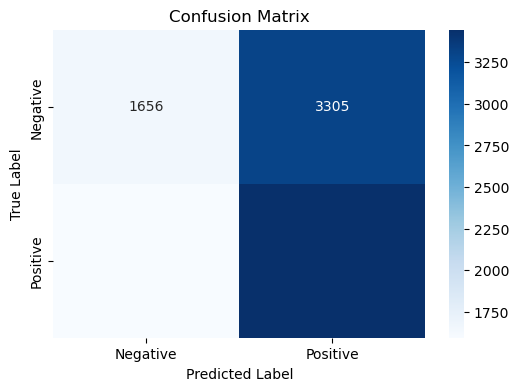

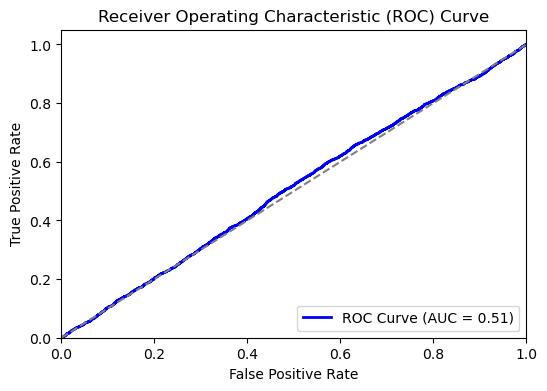

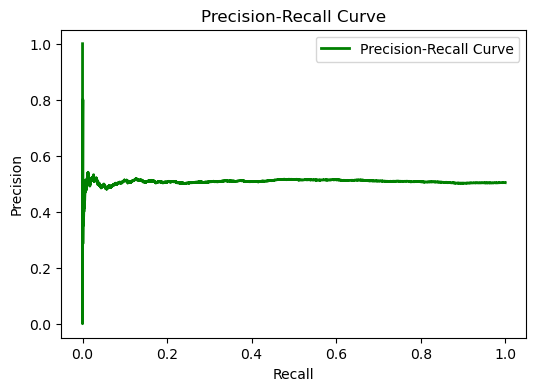

In [89]:
#A more graphical illustration
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_curve, auc, precision_recall_curve
)


## 🔹 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 🔹 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## 🔹 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="green", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

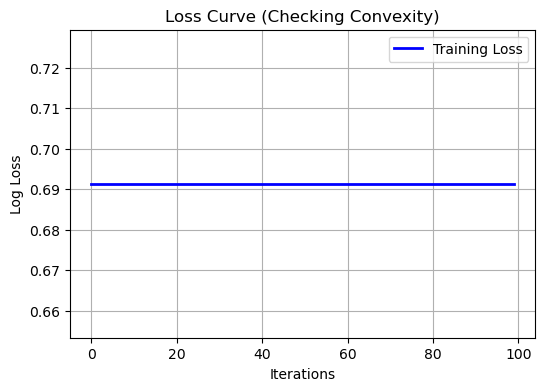

In [90]:
from sklearn.metrics import log_loss

# 🔹 Track Loss During Training
loss_values = []
num_epochs = 100  # Set the number of iterations

for i in range(num_epochs):
    lr_model.fit(X_train, y_train)  # Train for 1 iteration at a time
    y_pred_proba = lr_model.predict_proba(X_train)[:, 1]  # Get probabilities
    loss = log_loss(y_train, y_pred_proba)  # Compute Log Loss
    loss_values.append(loss)  # Store loss

# 🔹 Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(loss_values, label="Training Loss", color="blue", lw=2)
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Loss Curve (Checking Convexity)")
plt.legend()
plt.grid()
plt.show()

In [91]:

from nltk.corpus import stopwords
vectorizer = TfidfVectorizer(max_features=100)  # Convert text into TF-IDF vectors
X = vectorizer.fit_transform(movie_reviews['review'])


# 🔹 Step 1: Preprocess the text (cleaning)
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(words)

# 🔹 Step 6: Test with Sample Reviews
sample_reviews = ["This movie was fantastic!", "Horrible film, wasted my time."]
sample_reviews_cleaned = [preprocess_text(review) for review in sample_reviews]
sample_reviews_vectorized = vectorizer.transform(sample_reviews_cleaned)
sample_predictions = lr_model.predict(sample_reviews_vectorized)

for review, pred in zip(sample_reviews, sample_predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"\n🔹 Review: \"{review}\" --> Sentiment: {sentiment}")


🔹 Review: "This movie was fantastic!" --> Sentiment: Positive

🔹 Review: "Horrible film, wasted my time." --> Sentiment: Negative
